# Explore Weather Trends Project


## 1. Extract The Data

In order to get the data, I ran two simple queries to return the entriety of the two available datasets. As there were twp files, I ran each command, and saved the results as .csv files, each containing their output. This would require me to do a little processing to subset the data, but I was up for the challenge:

``` mysql
    SELECT * FROM city_data;
    SELECT * FROM global_data;
```

## 2. Calculating A Moving Average

In order to make things a little more interesting, I decided to calculate the moving average for New York (and every other city in the data set) using Pandas, a commonly available Python package. To do that, I used the city data file, and imported it as a dataframe:

In [20]:
import pandas as pd
df = pd.DataFrame(pd.read_csv("city_data.csv"))

From there, I first wanted to create a moving average just for the city of New York. In order to just fetch the New York data, I created a subset of the dataframe using boolean selection to return rows where the column 'City' contained the label 'New York'. I then copied this, and saved it as a separate dataframe: 

In [21]:
ny_data = df.city == 'New York'
ny_df = df[ny_data].copy()

Before we get to the work of actually calculating the moving average, we have to do two steps of preprocessing work: 


1. Because there's one temperature sample per year, I'll use the year as the index for the dataframe.
2. Remove the `NaN` entries by "forward filling" the data using the last available sample. There were only five `NaN` records in the dataset, but it will give us five more moving average samples where we didn't have any:


In [22]:
# Replace the of the dataset with the year of the sample
ny_df.set_index('year', inplace=True)

# Replace any NaN values with a forward fill of previous year data
ny_df.loc[:,'avg_temp'] = ny_df.loc[:, 'avg_temp'].ffill()

With my New York data in hand, the next step was to actually calculate the moving average. Rather than reinventing the wheel and writing a procedure to calculate the moving average for every cell in a column, I used Pandas's built-in `.rolling()` function:

In [23]:
ny_df['rolling_avg'] = ny_df.iloc[:,2].rolling(window=7).mean()

Breaking this down a little bit:

The assignment statement to the left of the '=' sign appends a new column to the dataframe, in this case, with the label 'rolling_avg'. 

To the right of the assignment statement, we use the `.iloc` and Panda's slicing logic to access every row in the fourth column, which in this case, contains the temperature data. 

By appending a `rolling()` command with the window size we want passed as an argument (in this case seven), we create a series, wherein a moving average of window size seven is appended to the existing `ny_df` dataframe. This will result in the first six rows returning `NaN` for the rolling average, and printing after that. Sure enough:

In [24]:
ny_df.head(7)

,city,country,avg_temp,rolling_avg
year,,,,
1743,New York,United States,3.26,NaN
1744,New York,United States,11.66,NaN
1745,New York,United States,1.13,NaN
1746,New York,United States,1.13,NaN
1747,New York,United States,1.13,NaN
1748,New York,United States,1.13,NaN
1749,New York,United States,1.13,2.938571


Now let's take what we've learned and apply it to our global weather data. I'm going to gloss over the implementation details here. All that's needed is to know we're pulling in another .csv file for the global data and creating our moving average. 

In [25]:
# Import our data
global_df = pd.DataFrame(pd.read_csv("global_data.csv"))

# Use our year as our dataframe index
global_df.set_index('year', inplace=True)

# Calculate our rolling average using the same method as before
global_df['rolling_avg'] = global_df.iloc[:,0].rolling(window=7).mean()

## 3. Plotting Our Trends Data

Now for the pretty parts! Let's pull up a simple line chart, comparing New York's data to overall global trends. For this, we'll use a simple line chart from the Python package matplotlib.

A few considerations here:
- I went out of my way in the pre-processing step to make sure that our chart was indexed by the year that the temperature was recorded. 
- I also wanted to make sure that our axes were labeled, with the temperature being along the Y, and the year along the X, so we can visualize trends as the years go by. 
- Both moving averages needed to utilize the same windows in order to make sure the trends we deduced were relevant.
- We'll need to include a legend to make sure we know which data is which, and that each line is colored differently. 

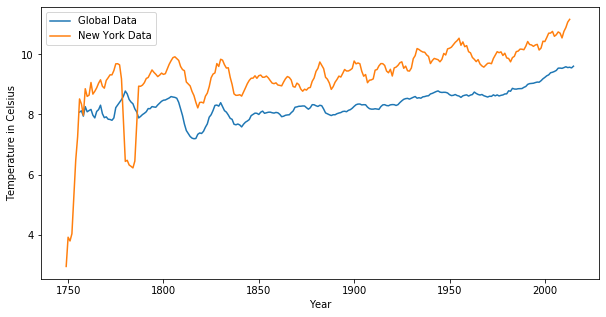

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=[10,5])
plt.grid(False)
plt.xlabel('Year')
plt.ylabel('Temperature in Celsius')
plt.plot(global_df['rolling_avg'], label='Global Data')
plt.plot(ny_df['rolling_avg'], label='New York Data')
plt.legend(loc=2)

## 3. Data Observation and Additional Analysis

I'm no climate scientist, but a couple of things immediately stand out:  


1. The New York almost always sits above the global data. As a New Yorker, this makes sense to me intiutively. New York's one of the largest, most densely populated cities on the planet. The large number of residents results in higher levels of air pollution, and less green space means that all that sunlight is bouncing off the concrete, making the air hotter. But this data doesn't tell us that but it's just a hunch for now.
2. New York's data typically follows global trends. Major peaks and valleys, such as those seen around the 1820's and '30s, mirror New York's data closely, meaning we've lined our data up properly. 
3. New York's data tends to be more cyclical than the global data. Despite having the same window used to calculate our moving average, the New York data tends to "bounce" more than the global data, as seen between 1900 and 1950. 
4. Something in the data around 1770 pulled New York's data way down, so far that even correcting for outliers using a moving average resulted in a dramatic drop below global temperatures. This might also warrant some further investigation. Maybe a particularly long and harsh winter, or maybe someone moved a decimal point. 

But we've got all this data. Let's have some more fun with it. 


### Bonus: Additional Cities

For one, let's add a few more cities to this. New York wasn't the first city to industrialize, that would be probably be London. I wonder if they sit even higher than New York given their history of early industrialization.

It would also be insightful to add a few more "reference" cities, ones that we know will be hotter or colder than average. I used to live in Singapore, and it sits right on the equator, so it's mighty hot. I'd also wager that another city further north, like Moscow, is probably colder than either New York or Londong. So let's pull in all of their data and plot another chart:



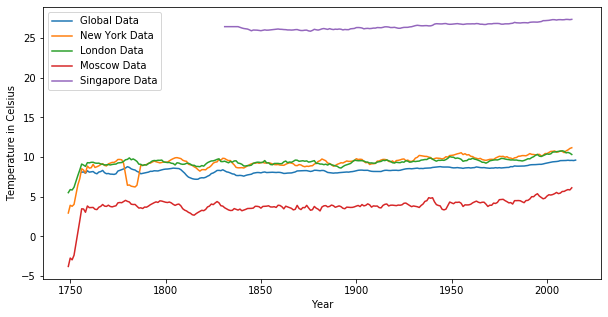

In [30]:
# Add in our London Data
london_data = (df.city == 'London') & (df.country == 'United Kingdom')
london_df = df[london_data].copy()
london_df.set_index('year', inplace=True)
london_df.loc[:,'avg_temp'] = london_df.loc[:, 'avg_temp'].ffill()
london_df['rolling_avg'] = london_df.iloc[:,2].rolling(window=7).mean()

# Pulling in our Moscow Data
moscow_data = (df.city == 'Moscow') & (df.country == 'Russia')
moscow_df = df[moscow_data].copy()
moscow_df.set_index('year', inplace=True)
moscow_df.loc[:,'avg_temp'] = moscow_df.loc[:, 'avg_temp'].ffill()
moscow_df['rolling_avg'] = moscow_df.iloc[:,2].rolling(window=7).mean()

# Pulling in our Singapore Data
sg_data = df.city == 'Singapore'
sg_df = df[sg_data].copy()
sg_df.set_index('year', inplace=True)
sg_df.loc[:,'avg_temp'] = sg_df.loc[:, 'avg_temp'].ffill()
sg_df['rolling_avg'] = sg_df.iloc[:,2].rolling(window=7).mean()

# Add it to our existing matplotlib chart
plt.figure(figsize=[10,5])
plt.grid(False)
plt.xlabel('Year')
plt.ylabel('Temperature in Celsius')
plt.plot(global_df['rolling_avg'], label='Global Data')
plt.plot(ny_df['rolling_avg'], label='New York Data')
plt.plot(london_df['rolling_avg'], label = 'London Data')
plt.plot(moscow_df['rolling_avg'], label = 'Moscow Data')
plt.plot(sg_df['rolling_avg'], label = 'Singapore Data')
plt.legend(loc=2)

While our axes change considerably, it does provide some interesting additional context!

- Our "reference cities" preform as expected. Singapore is far hotter than any other city, hovering far above the rest of our data, and Moscow lies pretty far below the global data. 
- This chart also more clearly indicates a sharp rise in temperature occured all across the global in the late 1750s. My inner economic historian tells me this was probably the advent of industrialization and the rise of capitalism.
- Singapore doesn't appear on our chart until near 1850, seeing as Sir Stamford Raffles didn't formally colonize it until 1819! Although, judging by how high and flat that line is, I'd imagine it's safe to say it was still pretty hot even before he got there.  

Hopefully, a little more analysis might reveal a little more in the future!